# Project for Data anonymization

Please indicate your name:
- BROIHIER Loic
- DRUGEON Alexis
- GUILLEMIN Baptiste
- SOAHITA Salvoldi Holzer


The goal of this project is to attack a neural network during its federated training. We assume that you are the attacker, and thus that you have directly access to the update of your victim. This attack is described in the paper [Deep leakage from gradient](https://arxiv.org/abs/1906.08935).

You do not need to understand the maths in detail in order to have a successful project. However, I welcome questions on these aspect.

Because you are on your own (no TP during the lecture) all the questions can be done easily, either by looking at the [official implementation](https://github.com/mit-han-lab/dlg) or by doing very simple Python code. If you are stuck, first try to google your problem and verify that the content of the variables. If it doesn't solve the problem, send me a message at cyffers@aivancity.ai with a description of your problem and what you tried to solve it, and the link to your colab. There are TODO every time you need to do complete something.

## Question 1

Read the paper [Deep leakage from gradient](https://arxiv.org/abs/1906.08935) and answer the following questions, with at least one sentence to justify each bullet point for full mark.

**- is it a black box or a white box attack?**

It is a black box attack because the architecture of the model and its weights are not known. Attackers only have the gradient to obtain the real training data.

**- is it a federated or a standalone setting?**

It is a federated setting because the gradients are exchanged by collaborative learning and distributed training. Each client does not share his training data and he only communicates the gradient during training.

**- is it a passive or an active attack?**

It is an active attack because the attacker uses the publicly shared
gradients to perform his attack. Therefore, the attacker is a member of the federate learning.

**- is it a supervised or unsupervised attack?**

Unsupervised attacks are attacks in which the attacker does not have access to labeled training data. It is an unsupervised attack; the attacker doesn't need to have an example of the real dataset to perform the attack. Attackers creates their own data to accomplish its attack alongside 'dummmy labels'. Thus, DLG doesn't need prior knowledge about the data and their labels. 



## Question 2

**Summarize with your own words how the attack works. (around 5 lines)**

The Deep Leakage from Gradients is an algorithm to obtain the training inputs and the labels of a model. Firstly, we begin by generating in a random way a pair of dummy inputs and dummy labels. Secondly, we use these inputs and labels to do forward and backward propagation for the neural network. Then, we derivate the gradients from these data. Finally, we minimize the distance between our result gradient and the shared gradient to guess the original data. Therefore,  when the distance between these gradients becomes very smaller, the resulting images that we get from the attack with these data becomes also better.


**What would happen if the model was very simple (for example a model with only 3 or 4 parameters, or a little decision tree) instead of being a neural network?**

If the model was very simple instead of being a neural network, we didn't need to calculate a gradient. We just tried random values for the inputs and compared the result given and the real result to guess the real data. 

# Implementing the setting

In this part we reproduce the implementation of the paper for CIFAR 100. Feel free to copy paste some part of the code.

First, we import some utils, downlad the dataset and define the neural network and the loss.

In [ ]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(0)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

Running on cpu


In [ ]:
dst = datasets.CIFAR100("~/.torch", download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch


In [ ]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target


tt = transforms.ToPILImage()

Now we need to compute the gradient that will serve for our attack. We thus fix one of the sample of the datset (here the number 25) that will be our target/victim.

## Question 3
Complete the code to save the gradient in the variable `victim_dy_dx`

In [ ]:
from matplotlib.cbook import get_label
img_index = 25
# Some useful preprocessing
gt_data = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])(dst[img_index][0]).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# TODO
# compute the output given by the network net we have define (one line)
pred = net(gt_data)
# compute the cross entropy line (one line)
cross_entropy = cross_entropy_for_onehot(pred, gt_onehot_label)
# compute the gradient (one line)
dy_dx = torch.autograd.grad(cross_entropy, net.parameters())
# detach the gradient in order to be able to work with it afterwards
victim_dy_dx = list((_.detach().clone() for _ in dy_dx))


# Question 4

In order to know what we want to reconstruct, print the true label of the sample and show the picture (using matplotlib and PIL).

Note that this knowledge is not used during the attack.

Label = 84


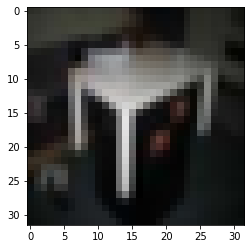

In [ ]:
# TODO
# Print the label
print(f"Label = {gt_label[0]}")
# Show image
plt.imshow(tt(gt_data[0].cpu()))

# Implementation of the attack

## Question 5

We first need a starting point with a dummy sample and a dummy label. Implements the line 2 of the Algorithm 1

$$\mathrm{x}^{\prime}{ }_1 \leftarrow \mathcal{N}(0,1), \mathbf{y}_1^{\prime}{ }_1 \leftarrow \mathcal{N}(0,1)$$

Label = -0.13498961925506592


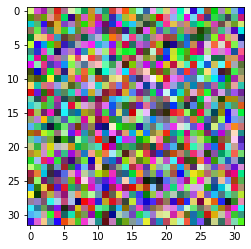

In [ ]:
# TODO
# a line to generate the dummy sample
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# print the label and show the sample
print(f"Label = {dummy_label[0][img_index]}")
plt.imshow(tt(dummy_data[0].cpu()))

## Question 6

Complete the [closure](https://pytorch.org/docs/stable/optim.html#optimizer-step-closure) to minimize the difference between the gradient of the victim and our dummy sample. Then we run 300 steps of gradient descent to minimize the difference. We are running our attack!

In [ ]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        # clear the gradient (one line)
        optimizer.zero_grad()
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)

        # compute the output of our network on the dummy sample (one line)
        dummy_pred = net(dummy_data)

        # compute the cross entropy loss
        dummy_loss =  cross_entropy_for_onehot(dummy_pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, victim_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
    history.append(tt(dummy_data[0].cpu()))

Let's now visualize the result of our attack

## Question 7

Print the predicted label and the final reconstruction image.

Label = -0.3161974251270294


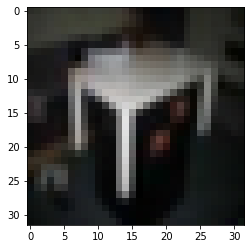

In [ ]:
print(f"Label = {dummy_label[0][img_index]}")
plt.imshow(history[299])

*If you are in PG4, congratulations, if you have reached this point, you have a passing grade.*



## Question 8

Run the attack on 10 ten different victims samples belonging to different classes and show side by side the original sample and its reconstruction.

Victim number=9


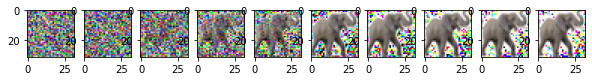

Victim number=15


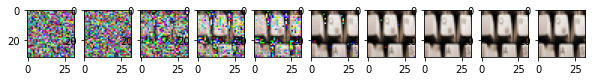

Victim number=27


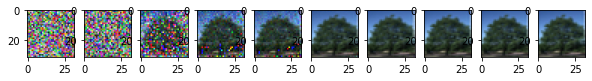

Victim number=39


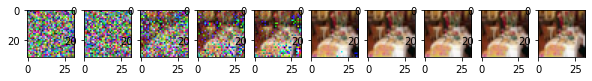

Victim number=43


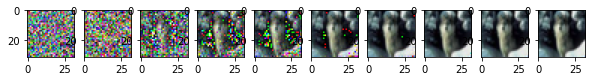

Victim number=52


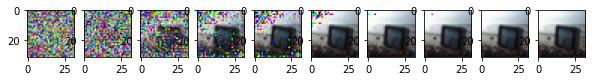

Victim number=65


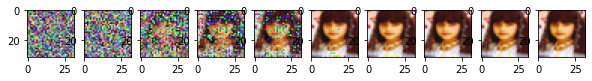

Victim number=79


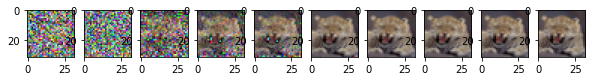

Victim number=90


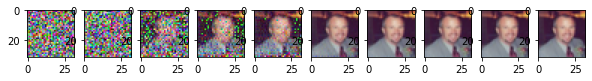

Victim number=99


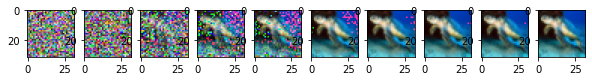

In [ ]:
def do_dlg_attack(img_index):
    # Some useful preprocessing
    gt_data = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])(dst[img_index][0]).to(device)

    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # compute the output given by the network net we have define (one line)
    pred = net(gt_data)
    # compute the cross entropy line (one line)
    cross_entropy = cross_entropy_for_onehot(pred, gt_onehot_label)
    # compute the gradient (one line)
    dy_dx = torch.autograd.grad(cross_entropy, net.parameters())
    # detach the gradient in order to be able to work with it afterwards
    victim_dy_dx = list((_.detach().clone() for _ in dy_dx))
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    for iters in range(300):
        def closure():
            # clear the gradient (one line)
            optimizer.zero_grad()
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)

            # compute the output of our network on the dummy sample (one line)
            dummy_pred = net(dummy_data)

            # compute the cross entropy loss
            dummy_loss = cross_entropy_for_onehot(dummy_pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, victim_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
        history.append(tt(dummy_data[0].cpu()))

    return history

# Attack the victims
Victims_index=[9,15,27,39,43,52,65,79,90,99]
history_dlg=[]
for i in range(10):
    history_dlg.append(do_dlg_attack(Victims_index[i]))

# Plotting
def plot_dlg_attack(history):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1, 10, figsize=(10,10))
    ax1.imshow(history[0])
    ax2.imshow(history[10])
    ax3.imshow(history[25])
    ax4.imshow(history[40])
    ax5.imshow(history[50])
    ax6.imshow(history[100])
    ax7.imshow(history[150])
    ax8.imshow(history[200])
    ax9.imshow(history[250])
    ax10.imshow(history[299])
    plt.show()

for i,hist_dlg in enumerate(history_dlg):
    print(f"Victim number={Victims_index[i]}")
    plot_dlg_attack(hist_dlg)

*If you are in PG5, congratulations, if you have reached this point, you have a passing grade.*

Sometimes, there are still artefacts at the end of training. It means that the gradient descent is stuck in a local minima. A simple way to mitigate this issue is to run the attack several times, starting from different dummy samples, and to output the best reconstruction. In order to know which trial is the best, we take the one with the smaller norm $$\lVert \nabla W_{victim} - \nabla W_{attacker} \rVert$$ and take the best over 5 runs

## Question 9

Redo the attack with this modification.

Victim number=9


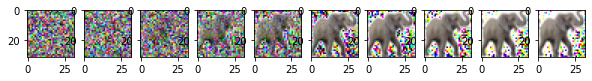

Victim number=15


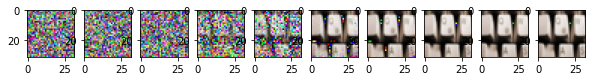

Victim number=27


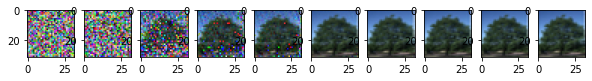

Victim number=39


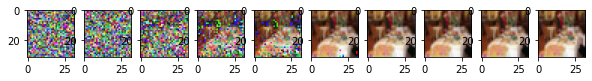

Victim number=43


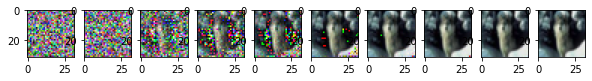

Victim number=52


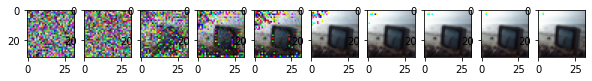

Victim number=65


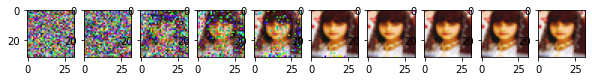

Victim number=79


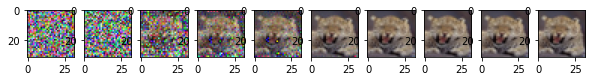

Victim number=90


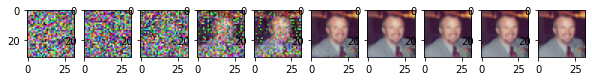

Victim number=99


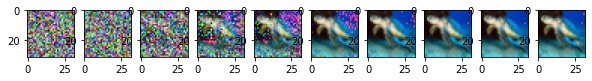

In [ ]:
# TODO
# you need to copy paste and add the comparison between the norm of the weights
def do_attack_against_local_minima(img_index):
    # Some useful preprocessing
    gt_data = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])(dst[img_index][0]).to(device)

    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # compute the output given by the network net we have define (one line)
    pred = net(gt_data)
    # compute the cross entropy line (one line)
    cross_entropy = cross_entropy_for_onehot(pred, gt_onehot_label)
    # compute the gradient (one line)
    dy_dx = torch.autograd.grad(cross_entropy, net.parameters())
    # detach the gradient in order to be able to work with it afterwards
    victim_dy_dx = list((_.detach().clone() for _ in dy_dx))

    nb_run = 5
    min_norms = 1000000
    min_history = []

    # 5 Run
    for i in range(nb_run):
        dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
        dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
        optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

        history = []
        last_grad_diff = 0
        for iters in range(300):
            def closure():
                # clear the gradient (one line)
                optimizer.zero_grad()
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)

                # compute the output of our network on the dummy sample (one line)
                dummy_pred = net(dummy_data)

                # compute the cross entropy loss
                dummy_loss = cross_entropy_for_onehot(
                    dummy_pred, dummy_onehot_label)

                dummy_dy_dx = torch.autograd.grad(
                    dummy_loss, net.parameters(), create_graph=True)

                grad_diff = 0
                grad_count = 0
                for gx, gy in zip(dummy_dy_dx, victim_dy_dx):
                    grad_diff += ((gx - gy) ** 2).sum()
                    grad_count += gx.nelement()
                grad_diff.backward()

                return grad_diff

            optimizer.step(closure)
            if iters % 10 == 0:
                current_loss = closure()
            history.append(tt(dummy_data[0].cpu()))
            last_grad_diff = closure()

        # take the one with the smaller norm
        if (last_grad_diff < min_norms):
            min_norms = last_grad_diff
            min_history = history

    return min_history


# Attack the victims
Victims_index=[9,15,27,39,43,52,65,79,90,99]
history_against_minima=[]
for i in range(10):
    history_against_minima.append(do_attack_against_local_minima(Victims_index[i]))

# Plotting
def plot_against_minima_attack(history):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1, 10, figsize=(10,10))
    ax1.imshow(history[0])
    ax2.imshow(history[10])
    ax3.imshow(history[25])
    ax4.imshow(history[40])
    ax5.imshow(history[50])
    ax6.imshow(history[100])
    ax7.imshow(history[150])
    ax8.imshow(history[200])
    ax9.imshow(history[250])
    ax10.imshow(history[299])
    plt.show()

for i,hist_against_minima in enumerate(history_against_minima):
    print(f"Victim number={Victims_index[i]}")
    plot_against_minima_attack(hist_against_minima)


Even if this method is already successful, the minimzation is sometimes unstable. In fact, a newer paper has shown that it is possible to extract for the cross entropy loss the labels in a much more reliable way.

Read the paper [iDLG: Improved Deep Leakage from Gradients](https://arxiv.org/pdf/2001.02610.pdf) to understand this method.

## Question 10

**Summarize with your own words how the label reconstruction works. (around 5 lines)**

The Improved Deep Leakage from Gradients has two parts, first the detection of the ground-truth labels from the shared gradients, and second, the extraction of data from these correct labels. With the positive activation function as ReLU and Sigmoid in the output layer, the gradient and its derivative have the same sign. Therefore, the gradient is between -1 and 0 when the labels are true and when it is false, it is between 0 and 1, so it is easy to find the ground-truth label. Then, we create random dummy data and calculate a gradient with it and the true labels. After, we try to minimize the distance between the dummy gradient and the true gradient. Finally, we update the dummy gradient based on that minimum distance.


## Question 11

Implement the prediction the ground-truth label. 
More exactly, fix 5 different samples of the dataset. Compute their gradients. Compute their label thanks to the iDLG trick and check that they are correct.

You may find inspiration in [the official implementation of the paper](https://github.com/PatrickZH/Improved-Deep-Leakage-from-Gradients/blob/master/iDLG.py)

In [ ]:
# TODO
def get_true_label(img_index):
    # Some useful preprocessing
    gt_data = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])(dst[img_index][0]).to(device)

    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    return gt_label.item()

def predict_ground_truth_label(img_index):
    # Some useful preprocessing
    gt_data = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])(dst[img_index][0]).to(device)

    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # compute the output given by the network net we have define (one line)
    pred = net(gt_data)
    # compute the cross entropy line (one line)
    cross_entropy = cross_entropy_for_onehot(pred, gt_onehot_label)
    # compute the gradient (one line)
    dy_dx = torch.autograd.grad(cross_entropy, net.parameters())
    label_pred = torch.argmin(torch.sum(dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
    return label_pred

samples=[25,35,45,55,65]
for s in samples:
    print(f"Predicted label of num={s} is {predict_ground_truth_label(s).item()} and True label of num={s} is {get_true_label(s)}")

Predicted label of num=25 is 84 and True label of num=25 is 84
Predicted label of num=35 is 22 and True label of num=35 is 22
Predicted label of num=45 is 76 and True label of num=45 is 76
Predicted label of num=55 is 6 and True label of num=55 is 6
Predicted label of num=65 is 35 and True label of num=65 is 35


## Question 12

Now that we have the label, we can run the attack by only minimizing the loss with respect to the dummy sample.

Implement the modified attack and compare its efficiency by plotting the reconstructed image all the 10 steps for the initial DLG reconstruction and for the iDLG reconstruction.

In [ ]:
# TODO implement the modified attack
# The optimizer is now only a function of the sample
# the dummy loss is taken with the fix reconstructed label
def do_idlg_attack(img_index):
  # Some useful preprocessing
  gt_data = transforms.Compose([
      transforms.Resize(32),
      transforms.CenterCrop(32),
      transforms.ToTensor()
  ])(dst[img_index][0]).to(device)

  gt_data = gt_data.view(1, *gt_data.size())
  gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
  gt_label = gt_label.view(1, )
  gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

  # compute the output given by the network net we have define (one line)
  pred = net(gt_data)
  # compute the cross entropy line (one line)
  cross_entropy = cross_entropy_for_onehot(pred, gt_onehot_label)
  # compute the gradient (one line)
  dy_dx = torch.autograd.grad(cross_entropy, net.parameters())
  # detach the gradient in order to be able to work with it afterwards
  victim_dy_dx = list((_.detach().clone() for _ in dy_dx))
  dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
  dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

  # predict the ground-truth label
  label_pred=predict_ground_truth_label(img_index)

  #optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
  optimizer = torch.optim.LBFGS([dummy_data, ] )

  history = []
  for iters in range(300):
      def closure():
          # clear the gradient (one line)
          optimizer.zero_grad()

          dummy_onehot_label = F.softmax(dummy_label, dim=-1)

          # compute the output of our network on the dummy sample (one line)
          dummy_pred = net(dummy_data)

          # compute the cross entropy loss
          criterion = nn.CrossEntropyLoss().to(device)
          dummy_loss = criterion(dummy_pred, label_pred)

          dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
          
          grad_diff = 0
          grad_count = 0
          for gx, gy in zip(dummy_dy_dx, victim_dy_dx): 
              grad_diff += ((gx - gy) ** 2).sum()
              grad_count += gx.nelement()
          grad_diff.backward()

          return grad_diff

      optimizer.step(closure)
      if iters % 10 == 0: 
          current_loss = closure()
      history.append(tt(dummy_data[0].cpu()))
  return history

In [ ]:
# run the two attacks
# DLG Attack 
Victims_index=[9,15,27,39,43,52,65,79,90,99]
history_dlg=[]
for i in range(10):
    history_dlg.append(do_dlg_attack(Victims_index[i]))

# iDlG Attack 
Victims_index=[9,15,27,39,43,52,65,79,90,99]
history_idlg=[]
for i in range(10):
    history_idlg.append(do_idlg_attack(Victims_index[i]))


DLG reconstruction: 

Victim number=9


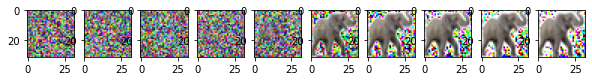

Victim number=15


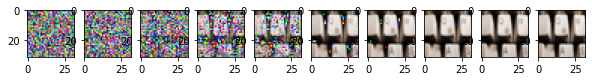

Victim number=27


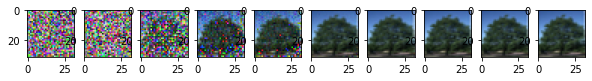

Victim number=39


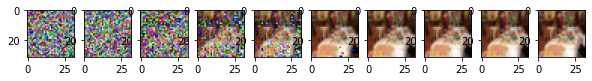

Victim number=43


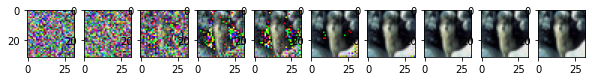

Victim number=52


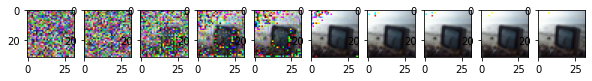

Victim number=65


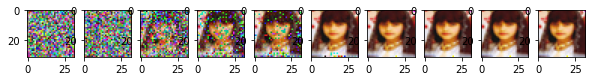

Victim number=79


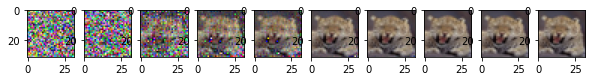

Victim number=90


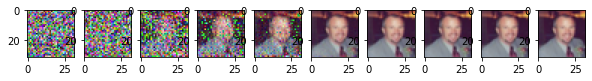

Victim number=99


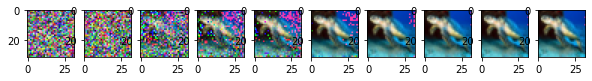


iDLG reconstruction: 

Victim number=9


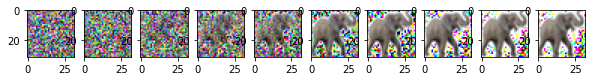

Victim number=15


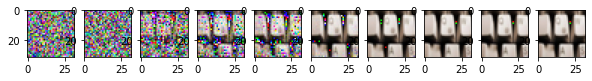

Victim number=27


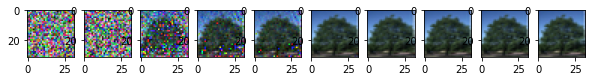

Victim number=39


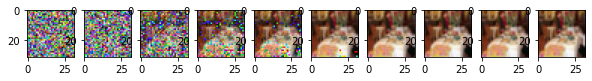

Victim number=43


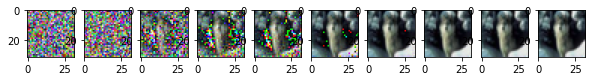

Victim number=52


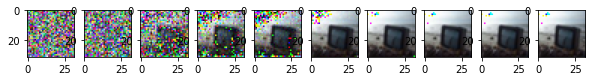

Victim number=65


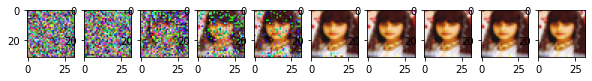

Victim number=79


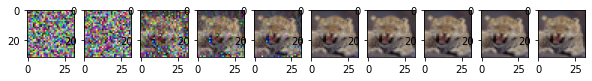

Victim number=90


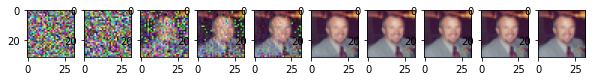

Victim number=99


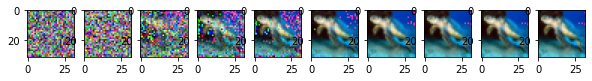

In [ ]:
# show the reconstruction

# DLG
print("DLG reconstruction: \n")
def plot_dlg_attack(history):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1, 10, figsize=(10,10))
    ax1.imshow(history[0])
    ax2.imshow(history[10])
    ax3.imshow(history[25])
    ax4.imshow(history[40])
    ax5.imshow(history[50])
    ax6.imshow(history[100])
    ax7.imshow(history[150])
    ax8.imshow(history[200])
    ax9.imshow(history[250])
    ax10.imshow(history[299])
    plt.show()

for i,hist_dlg in enumerate(history_dlg):
    print(f"Victim number={Victims_index[i]}")
    plot_dlg_attack(hist_dlg)

# IDLG
print("\niDLG reconstruction: \n")
def plot_idlg_attack(history):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1, 10, figsize=(10,10))
    ax1.imshow(history[0])
    ax2.imshow(history[10])
    ax3.imshow(history[25])
    ax4.imshow(history[40])
    ax5.imshow(history[50])
    ax6.imshow(history[100])
    ax7.imshow(history[150])
    ax8.imshow(history[200])
    ax9.imshow(history[250])
    ax10.imshow(history[299])
    plt.show()

for i,hist_idlg in enumerate(history_idlg):
    print(f"Victim number={Victims_index[i]}")
    plot_idlg_attack(hist_idlg)


*Congratulations! You finished the mandatory part of the project!*

## Question 13

Run the attack on another model or another dataset.

In [ ]:
# TODO

## Question 14 (hard)

The previous reconstruction was performed on a gradient of a unique sample. In practice, we often use (mini)-batches, which means that the attacker would access the aggregation of several samples. 

It is possible to adapt the previous attack in this case, as described in the section 3.2. Implement the modified attack

In [ ]:
# TODO